In [31]:
# Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [33]:
df = pd.read_csv('./Dataset/winequality-red.csv', usecols = ['alcohol', 'volatile acidity', 'sulphates', 'density'])
df.sample(5)

,volatile acidity,density,sulphates,alcohol
1110,0.530,0.99593,0.64,10.0
33,0.605,0.99930,0.52,9.4
243,0.210,1.00005,0.84,9.2
130,0.745,0.99680,0.66,9.4
358,0.430,1.00000,0.85,10.4


In [35]:
# Introduce Missing Values Artificially (MCAR Pattern)
# Since the original dataset has no missing values, we'll create some artificially
np.random.seed(42)
missing_rate = 0.15  # 15% missing values

df_with_missing = df.copy()

# Introduce missing values randomly in each column
for col in df_with_missing.columns:
    missing_indices = np.random.choice(
        df_with_missing.index, 
        size=int(len(df_with_missing) * missing_rate), 
        replace=False
    )
    df_with_missing.loc[missing_indices, col] = np.nan

print("Missing values introduced:")
print(df_with_missing.isnull().sum())
print(f"\nMissing value percentages:")
print((df_with_missing.isnull().sum() / len(df_with_missing) * 100).round(2))

Missing values introduced:
volatile acidity    239
density             239
sulphates           239
alcohol             239
dtype: int64

Missing value percentages:
volatile acidity    14.95
density             14.95
sulphates           14.95
alcohol             14.95
dtype: float64


In [37]:
# MICE Implementation with Loop to Show Iterations
# Separate features and target
X = df_with_missing[['alcohol', 'volatile acidity', 'sulphates']].copy()
y = df_with_missing['density'].copy()

print("Features (X) with missing values:")
print(X.isnull().sum())
print(f"\nTarget (y) missing values: {y.isnull().sum()}")

# Initialize IterativeImputer (MICE)
mice_imputer = IterativeImputer(
    estimator=LinearRegression(),  # Base estimator for each feature
    max_iter=10,                   # Maximum number of iterations
    random_state=42,
    verbose=2                      # Show iteration progress
)

print("\n" + "="*50)
print("MICE (Iterative Imputation) Process Starting...")
print("="*50)


Features (X) with missing values:
alcohol             239
volatile acidity    239
sulphates           239
dtype: int64

Target (y) missing values: 239

MICE (Iterative Imputation) Process Starting...


In [39]:
# Perform MICE with Detailed Loop Visualization
# Store imputation results for each iteration
imputation_history = []
original_X = X.copy()

# Fit MICE imputer
print("Fitting MICE Imputer...")
X_imputed = mice_imputer.fit_transform(X)

# Convert back to DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

print("MICE Imputation completed!")
print(f"\nOriginal missing values:")
print(original_X.isnull().sum())
print(f"\nAfter MICE imputation:")
print(X_imputed_df.isnull().sum())


Fitting MICE Imputer...
[IterativeImputer] Completing matrix with shape (1599, 3)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.00
[IterativeImputer] Change: 0.655830391861226, scaled tolerance: 0.0149 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.01
[IterativeImputer] Change: 0.15143180455718674, scaled tolerance: 0.0149 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.01
[IterativeImputer] Change: 0.03664584700875506, scaled tolerance: 0.0149 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.01
[IterativeImputer] Change: 0.002832326114366901, scaled tolerance: 0.0149 
[IterativeImputer] Early stopping criterion reached.
MICE Imputation completed!

Original missing values:
alcohol             239
volatile acidity    239
sulphates           239
dtype: int64

After MICE imputation:
alcohol             0
volatile acidity    0
sulphates           0
dtype: int64


In [41]:
#  Manual MICE Loop Implementation for Better Visualization
def manual_mice_loop(X_missing, max_iterations=5):
    """
    Manual implementation of MICE to show iteration process
    """
    X_current = X_missing.copy()
    iteration_results = []
    
    # Initialize with mean imputation
    from sklearn.impute import SimpleImputer
    mean_imputer = SimpleImputer(strategy='mean')
    X_current = pd.DataFrame(
        mean_imputer.fit_transform(X_current), 
        columns=X_current.columns, 
        index=X_current.index
    )
    
    print("MICE Manual Loop Implementation:")
    print("="*40)
    
    for iteration in range(max_iterations):
        print(f"\nIteration {iteration + 1}:")
        X_prev = X_current.copy()
        
        # For each column with missing values
        for col in X_missing.columns:
            if X_missing[col].isnull().sum() > 0:
                # Get missing mask for current column
                missing_mask = X_missing[col].isnull()
                
                if missing_mask.sum() > 0:
                    # Features (other columns)
                    feature_cols = [c for c in X_current.columns if c != col]
                    X_features = X_current[feature_cols]
                    
                    # Target (current column)
                    y_target = X_current[col]
                    
                    # Train model on non-missing values
                    train_mask = ~missing_mask
                    model = LinearRegression()
                    model.fit(X_features[train_mask], y_target[train_mask])
                    
                    # Predict missing values
                    predictions = model.predict(X_features[missing_mask])
                    
                    # Update missing values
                    X_current.loc[missing_mask, col] = predictions
                    
                    print(f"  - Updated {missing_mask.sum()} missing values in '{col}'")
                    print(f"    Mean prediction: {predictions.mean():.4f}")
        
        # Store iteration result
        iteration_results.append(X_current.copy())
        
        # Check convergence (simplified)
        diff = np.abs(X_current.values - X_prev.values).max()
        print(f"  - Maximum change from previous iteration: {diff:.6f}")
        
        if diff < 1e-4:
            print(f"  - Converged after {iteration + 1} iterations!")
            break
    
    return X_current, iteration_results

# Run manual MICE
print("Running Manual MICE Implementation...")
X_mice_manual, iteration_history = manual_mice_loop(X, max_iterations=5)

Running Manual MICE Implementation...
MICE Manual Loop Implementation:

Iteration 1:
  - Updated 239 missing values in 'alcohol'
    Mean prediction: 10.4154
  - Updated 239 missing values in 'volatile acidity'
    Mean prediction: 0.5305
  - Updated 239 missing values in 'sulphates'
    Mean prediction: 0.6631
  - Maximum change from previous iteration: 0.655830

Iteration 2:
  - Updated 239 missing values in 'alcohol'
    Mean prediction: 10.4215
  - Updated 239 missing values in 'volatile acidity'
    Mean prediction: 0.5306
  - Updated 239 missing values in 'sulphates'
    Mean prediction: 0.6632
  - Maximum change from previous iteration: 0.125632

Iteration 3:
  - Updated 239 missing values in 'alcohol'
    Mean prediction: 10.4222
  - Updated 239 missing values in 'volatile acidity'
    Mean prediction: 0.5306
  - Updated 239 missing values in 'sulphates'
    Mean prediction: 0.6632
  - Maximum change from previous iteration: 0.034833

Iteration 4:
  - Updated 239 missing values

Comparison of Imputation Methods (Alcohol column):
    Original  Mean_Imputed  MICE_Sklearn  MICE_Manual
1        NaN     10.400895      9.886808     9.886814
9        NaN     10.400895     10.478241    10.478245
22       NaN     10.400895     10.605556    10.605563
23       NaN     10.400895     10.404084    10.404085
31       NaN     10.400895     10.154452    10.154451
40       NaN     10.400895     10.559031    10.559035
46       NaN     10.400895      9.815283     9.815293
48       NaN     10.400895     10.577130    10.577124
56       NaN     10.400895     10.561950    10.561947
58       NaN     10.400895     10.300221    10.300219


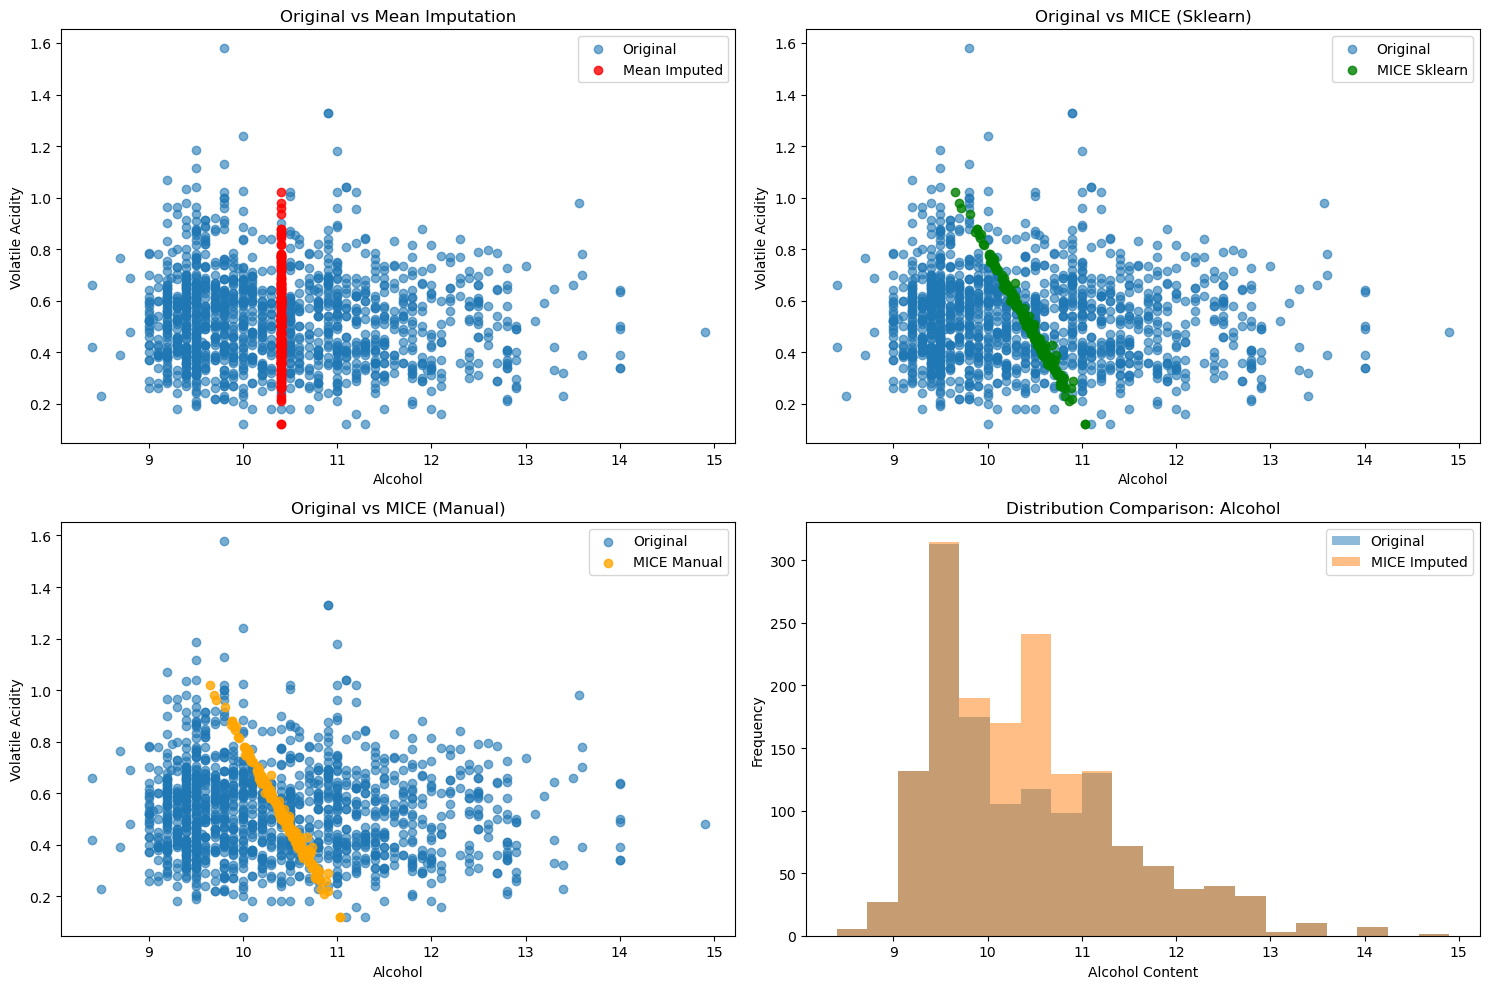

In [43]:
# Compare Different Imputation Results
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Original': original_X['alcohol'],
    'Mean_Imputed': SimpleImputer(strategy='mean').fit_transform(original_X)[:, 0],
    'MICE_Sklearn': X_imputed_df['alcohol'],
    'MICE_Manual': X_mice_manual['alcohol']
})

# Show comparison for first 20 rows where alcohol was missing
missing_alcohol_mask = original_X['alcohol'].isnull()
print("Comparison of Imputation Methods (Alcohol column):")
print("="*60)
print(comparison_df[missing_alcohol_mask].head(10))

# Visualize comparisons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original vs Mean Imputation
axes[0,0].scatter(original_X['alcohol'].dropna(), original_X['volatile acidity'].dropna(), alpha=0.6, label='Original')
axes[0,0].scatter(comparison_df['Mean_Imputed'][missing_alcohol_mask], 
                 original_X['volatile acidity'][missing_alcohol_mask], alpha=0.8, color='red', label='Mean Imputed')
axes[0,0].set_title('Original vs Mean Imputation')
axes[0,0].set_xlabel('Alcohol')
axes[0,0].set_ylabel('Volatile Acidity')
axes[0,0].legend()

# Original vs MICE (Sklearn)
axes[0,1].scatter(original_X['alcohol'].dropna(), original_X['volatile acidity'].dropna(), alpha=0.6, label='Original')
axes[0,1].scatter(X_imputed_df['alcohol'][missing_alcohol_mask], 
                 original_X['volatile acidity'][missing_alcohol_mask], alpha=0.8, color='green', label='MICE Sklearn')
axes[0,1].set_title('Original vs MICE (Sklearn)')
axes[0,1].set_xlabel('Alcohol')
axes[0,1].set_ylabel('Volatile Acidity')
axes[0,1].legend()

# Original vs MICE (Manual)
axes[1,0].scatter(original_X['alcohol'].dropna(), original_X['volatile acidity'].dropna(), alpha=0.6, label='Original')
axes[1,0].scatter(X_mice_manual['alcohol'][missing_alcohol_mask], 
                 original_X['volatile acidity'][missing_alcohol_mask], alpha=0.8, color='orange', label='MICE Manual')
axes[1,0].set_title('Original vs MICE (Manual)')
axes[1,0].set_xlabel('Alcohol')
axes[1,0].set_ylabel('Volatile Acidity')
axes[1,0].legend()

# Distribution comparison
axes[1,1].hist(original_X['alcohol'].dropna(), alpha=0.5, label='Original', bins=20)
axes[1,1].hist(X_imputed_df['alcohol'], alpha=0.5, label='MICE Imputed', bins=20)
axes[1,1].set_title('Distribution Comparison: Alcohol')
axes[1,1].set_xlabel('Alcohol Content')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

Prediction Results using MICE Imputed Features:
Mean Squared Error: 0.000003
R² Score: 0.2889
Root Mean Squared Error: 0.001690

Feature Importance (for predicting density):
            Feature  Coefficient  Abs_Coefficient
2         sulphates     0.001825         0.001825
0           alcohol    -0.000883         0.000883
1  volatile acidity    -0.000408         0.000408


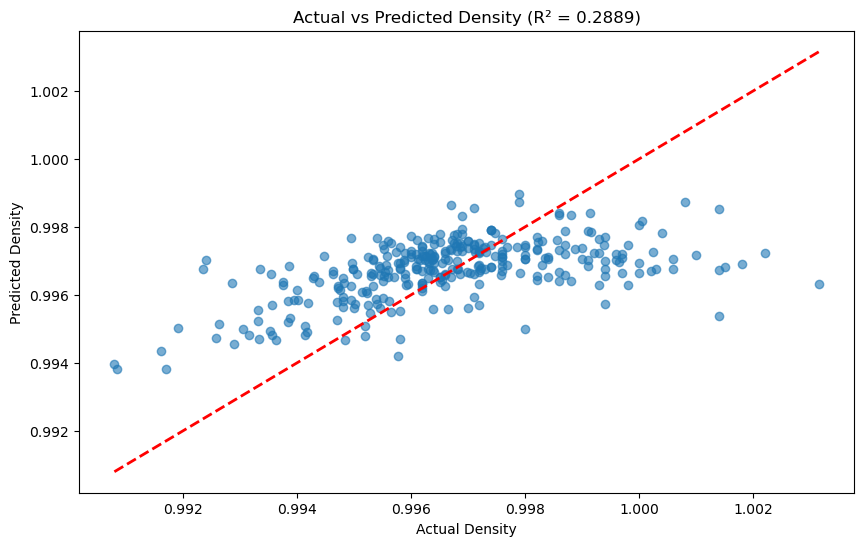

In [48]:
#  Predict Density using Imputed Features
# Split data for prediction
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed_df, df['density'], test_size=0.2, random_state=42
)

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Prediction Results using MICE Imputed Features:")
print("="*50)
print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.6f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nFeature Importance (for predicting density):")
print(feature_importance)

# Visualization of predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Density')
plt.ylabel('Predicted Density')
plt.title(f'Actual vs Predicted Density (R² = {r2:.4f})')
plt.show()

In [50]:
# Summary and MICE Process Explanation
print("MICE (Multiple Imputation by Chained Equations) Process Summary:")
print("="*70)
print("""
1. INITIALIZATION: Start with simple imputation (mean/median)

2. ITERATIVE PROCESS:
   For each feature with missing values:
   a) Use other features as predictors
   b) Train regression model on complete cases
   c) Predict missing values for current feature
   d) Update the feature with predicted values

3. REPEAT: Continue until convergence or max iterations

4. CONVERGENCE: Stop when changes between iterations are minimal

Key Advantages of MICE:
✓ Preserves relationships between variables
✓ More accurate than simple imputation methods
✓ Handles multiple missing patterns simultaneously
✓ Accounts for uncertainty in imputed values

Best Use Cases:
- Missing At Random (MAR) data
- Multiple features with missing values
- When feature relationships are important
""")

# Final comparison table
final_comparison = pd.DataFrame({
    'Method': ['Original Data', 'Mean Imputation', 'MICE (Sklearn)', 'MICE (Manual)'],
    'Missing_Values': [
        original_X.isnull().sum().sum(),
        0,
        0,
        0
    ],
    'Alcohol_Mean': [
        original_X['alcohol'].mean(),
        SimpleImputer(strategy='mean').fit_transform(original_X)[:, 0].mean(),
        X_imputed_df['alcohol'].mean(),
        X_mice_manual['alcohol'].mean()
    ],
    'Alcohol_Std': [
        original_X['alcohol'].std(),
        SimpleImputer(strategy='mean').fit_transform(original_X)[:, 0].std(),
        X_imputed_df['alcohol'].std(),
        X_mice_manual['alcohol'].std()
    ]
})

print("\nFinal Comparison of Imputation Methods:")
print(final_comparison.round(4))


MICE (Multiple Imputation by Chained Equations) Process Summary:

1. INITIALIZATION: Start with simple imputation (mean/median)

2. ITERATIVE PROCESS:
   For each feature with missing values:
   a) Use other features as predictors
   b) Train regression model on complete cases
   c) Predict missing values for current feature
   d) Update the feature with predicted values

3. REPEAT: Continue until convergence or max iterations

4. CONVERGENCE: Stop when changes between iterations are minimal

Key Advantages of MICE:
✓ Preserves relationships between variables
✓ More accurate than simple imputation methods
✓ Handles multiple missing patterns simultaneously
✓ Accounts for uncertainty in imputed values

Best Use Cases:
- Missing At Random (MAR) data
- Multiple features with missing values
- When feature relationships are important


Final Comparison of Imputation Methods:
            Method  Missing_Values  Alcohol_Mean  Alcohol_Std
0    Original Data             717       10.4009       1